<a href="https://colab.research.google.com/github/classic-21/Text-Summarization/blob/main/text_summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from attention import AttentionLayer

In [ ]:
df = pd.read_csv("summary_text.txt", encoding='ISO-8859-1', nrows = 20000)

In [ ]:
df.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [ ]:
df.drop_duplicates(subset=['text'],inplace=True)
df.dropna(axis=0,inplace=True)

In [ ]:
df.replace('', np.nan, inplace=True)
df.dropna(axis=0,inplace=True)

In [ ]:
df['headlines'] = df['headlines'].apply(lambda x : 'sostok '+ x + ' eostok')
df.head()

,headlines,text
0,sostok upGrad learner switches to career in ML...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,sostok Delhi techie wins free food from Swiggy...,Kunal Shah's credit card bill payment platform...
2,sostok New Zealand end Rohit Sharma-led India'...,New Zealand defeated India by 8 wickets in the...
3,sostok Aegon life iTerm insurance plan helps c...,"With Aegon Life iTerm Insurance plan, customer..."
4,"sostok Have known Hirani for yrs, what if MeTo...",Speaking about the sexual harassment allegatio...


In [ ]:
df['headlines'] = df['headlines'].apply(lambda x:x.lower())
df['text'] = df['text'].apply(lambda x:x.lower())

In [ ]:
df['headlines'] = df['headlines'].apply(lambda x: re.sub(r'"', "", x))
df['text'] = df['text'].apply(lambda x: re.sub(r'"', "", x))

In [ ]:
df['headlines'] = df['headlines'].apply(lambda x: re.sub(r'\([^)]*\)', "", x))
df['text'] = df['text'].apply(lambda x: re.sub(r'\([^)]*\)', "", x))

In [ ]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}
df["text"] = df["text"].apply(lambda x: " ".join(contraction_mapping[t] if t in contraction_mapping else t for t in x.split()))
df["headlines"] = df["headlines"].apply(lambda x: " ".join(contraction_mapping[t] if t in contraction_mapping else t for t in x.split()))


In [ ]:
special = { "%" : " percent", "$": "dollar", "@": " at", "&": " and", "+": " plus", "=": " equal",
            "°": "degree", "²": " squared", "³": " cubed", "¼": " one fourth", "½": " one half", "¾": " three fourths", "℃": " degrees Celsius",
            "℉": " degrees Fahrenheit", "×": " times"}

In [ ]:
for i in df['headlines'].head(1):
  num=0
  for j in special:
    if j in i:
      list = i.split(j)
      i = special[j].join(list)
    else:
      continue
  df['headlines'][num] = i
  num = num+1

In [ ]:
df['headlines'] = df['headlines'].apply(lambda x:re.sub("[^a-zA-Z0-9]", " ", x))
df['text'] = df['text'].apply(lambda x:re.sub("[^a-zA-Z0-9]", " ", x))

In [ ]:
df['text'] = df['text'].apply(lambda x: re.sub(r'\bs\b', "", x))
df['headlines'] = df['headlines'].apply(lambda x: re.sub(r'\bs\b', "", x))

In [ ]:
df.head()

,headlines,text
0,sostok upgrad learner switches to career in ml...,saurav kant an alumnus of upgrad and iiit b ...
1,sostok delhi techie wins free food from swiggy...,kunal shah credit card bill payment platform ...
2,sostok new zealand end rohit sharma led india ...,new zealand defeated india by 8 wickets in the...
3,sostok aegon life iterm insurance plan helps c...,with aegon life iterm insurance plan customer...
4,sostok have known hirani for yrs what if meto...,speaking about the sexual harassment allegatio...


In [ ]:
df['text'] = df['text'].apply(lambda x: re.sub(r'\s\s*', " ", x))
df['text'] = df['text'].apply(lambda x: re.sub(r'\s\s*', " ", x))

In [ ]:
df.replace('', np.nan, inplace=True)
df.dropna(axis=0,inplace=True)

In [ ]:
df["word_count_text"] = df["text"].apply(lambda x: len(str(x).split()))
for i in range(0, 100, 10):
  var = df["word_count_text"].values
  var = np.sort(var, axis = None)
  print("{} percentile value is {}".format(i, var[int(len(var)*(float(i)/100))]))
print("100 percentile value is {}".format(var[-1]))

0 percentile value is 1
10 percentile value is 56
20 percentile value is 58
30 percentile value is 59
40 percentile value is 60
50 percentile value is 60
60 percentile value is 61
70 percentile value is 61
80 percentile value is 62
90 percentile value is 63
100 percentile value is 74


In [ ]:
#looking further from 90th percentile
for i in range(90, 100):
  var = df["word_count_text"].values
  var = np.sort(var, axis = None)
  print("{} percentile value is {}".format(i, var[int(len(var)*(float(i)/100))]))
print("100 percentile value is {}".format(var[-1]))

90 percentile value is 63
91 percentile value is 63
92 percentile value is 64
93 percentile value is 64
94 percentile value is 64
95 percentile value is 64
96 percentile value is 65
97 percentile value is 65
98 percentile value is 66
99 percentile value is 66
100 percentile value is 74


In [ ]:
df["word_count_head"] = df["headlines"].apply(lambda x: len(str(x).split()))
for i in range(0, 100, 10):
  var = df["word_count_head"].values
  var = np.sort(var, axis = None)
  print("{} percentile value is {}".format(i, var[int(len(var)*(float(i)/100))]))
print("100 percentile value is {}".format(var[-1]))

0 percentile value is 3
10 percentile value is 10
20 percentile value is 11
30 percentile value is 12
40 percentile value is 12
50 percentile value is 12
60 percentile value is 13
70 percentile value is 13
80 percentile value is 14
90 percentile value is 14
100 percentile value is 20


In [ ]:
#looking further from 90th percentile
for i in range(90, 100):
  var = df["word_count_head"].values
  var = np.sort(var, axis = None)
  print("{} percentile value is {}".format(i, var[int(len(var)*(float(i)/100))]))
print("100 percentile value is {}".format(var[-1]))

90 percentile value is 14
91 percentile value is 15
92 percentile value is 15
93 percentile value is 15
94 percentile value is 15
95 percentile value is 15
96 percentile value is 15
97 percentile value is 16
98 percentile value is 16
99 percentile value is 16
100 percentile value is 20


In [ ]:
max_len_head=16
max_len_text=66

In [ ]:
x_tr, x_val, y_tr, y_val = train_test_split(df['text'], df['headlines'], test_size=0.3, random_state=42, shuffle=True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
embeddings_index = dict()
with open("/content/drive/MyDrive/glove.42B.300d.txt") as file:
  for line in file:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

In [ ]:
print("loaded {} words in dictionary".format(len(embeddings_index)))

loaded 1917494 words in dictionary


In [ ]:
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(x_tr)
x_sequences = x_tokenizer.texts_to_sequences(x_tr)
x_sequences_val = x_tokenizer.texts_to_sequences(x_val)

In [ ]:
word_index = x_tokenizer.word_index
print("total no of unique words found:",len(word_index))

total no of unique words found: 33608


In [ ]:
inter_words = set(embeddings_index.keys()).intersection(word_index.keys())
len(inter_words)

31298

In [ ]:
padded_seq_tr = pad_sequences(x_sequences, maxlen = max_len_text, padding = "post")
padded_seq_val = pad_sequences(x_sequences_val, maxlen = max_len_text, padding = "post")

In [ ]:
embedding_matrix = np.zeros((len(word_index)+1, 100))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

ValueError: could not broadcast input array from shape (300,) into shape (100,)

In [ ]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(y_tr)
y_sequences = y_tokenizer.texts_to_sequences(y_tr)
y_sequences_val = y_tokenizer.texts_to_sequences(y_val)

In [ ]:
y_word_index = y_tokenizer.word_index
print("total no of unique words found:",len(y_word_index))

total no of unique words found: 15642


In [ ]:
y_inter_words = set(embeddings_index.keys()).intersection(y_word_index.keys())
len(y_inter_words)

15117

In [ ]:
y_seq_tr = pad_sequences(y_sequences, maxlen = max_len_head, padding = "post")
y_seq_val = pad_sequences(y_sequences_val, maxlen = max_len_head, padding = "post")

In [ ]:
ind=[]
for i in range(len(y_seq_tr)):
    cnt=0
    for j in y_seq_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_seq_tr=np.delete(y_seq_tr,ind, axis=0)
padded_seq_tr=np.delete(padded_seq_tr,ind, axis=0)

In [ ]:
ind=[]
for i in range(len(y_seq_val)):
    cnt=0
    for j in y_seq_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_seq_val=np.delete(y_seq_val,ind, axis=0)
padded_seq_val=np.delete(padded_seq_val,ind, axis=0)

In [ ]:
y_embedding_matrix = np.zeros((len(y_word_index)+1, 100))
for word, i in y_word_index.items():
  y_embedding_vector = embeddings_index.get(word)
  if y_embedding_vector is not None:
    y_embedding_matrix[i] = y_embedding_vector

ValueError: could not broadcast input array from shape (300,) into shape (100,)

In [ ]:
latent_dim = 100
embedding_dim = 100

#Encoder
encoder_inputs = Input(shape=(max_len_text,))

enc_embedding_layer = Embedding(len(word_index)+1, embedding_dim, weights=[embedding_matrix], input_length=max_len_text, trainable=True)

#Embedding_layer
enc_emb =  enc_embedding_layer(encoder_inputs)
#enc_emb = Embedding(len(word_index)+1,embedding_dim,trainable=True)(encoder_inputs)
#encoder lstm1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(len(y_word_index)+1, embedding_dim, weights=[y_embedding_matrix], trainable=True)

#dec_emb_layer = Embedding(len(y_word_index)+1,embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(len(y_word_index)+1, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)
# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 66)]                 0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 66, 100)              3360900   ['input_12[0][0]']            
                                                                                                  
 lstm_4 (LSTM)               [(None, 66, 100),            80400     ['embedding_2[0][0]']         
                              (None, 100),                                                        
                              (None, 100)]                                                        
                                                                                            

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [ ]:
history=model.fit([padded_seq_tr, y_seq_tr[:,:-1]],
                  y_seq_tr.reshape(y_seq_tr.shape[0], y_seq_tr.shape[1], 1)[:,1:],
                  epochs=50,
                  callbacks=[es],
                  batch_size=64,
                  validation_data=([padded_seq_val,y_seq_val[:,:-1]], y_seq_val.reshape(y_seq_val.shape[0],y_seq_val.shape[1], 1)[:,1:])
                 )

Epoch 1/50
219/219 [==============================] - 200s 855ms/step - loss: 6.1473 - val_loss: 5.3477
Epoch 2/50
219/219 [==============================] - 180s 821ms/step - loss: 5.5639 - val_loss: 5.1864
Epoch 3/50
219/219 [==============================] - 177s 810ms/step - loss: 5.5070 - val_loss: 5.1537
Epoch 4/50
219/219 [==============================] - 178s 812ms/step - loss: 5.4593 - val_loss: 5.1012
Epoch 5/50
219/219 [==============================] - 178s 815ms/step - loss: 5.4150 - val_loss: 5.0673
Epoch 6/50
219/219 [==============================] - 179s 817ms/step - loss: 5.3531 - val_loss: 5.0350
Epoch 7/50
219/219 [==============================] - 180s 824ms/step - loss: 5.3081 - val_loss: 5.0105
Epoch 8/50
219/219 [==============================] - 184s 842ms/step - loss: 5.2680 - val_loss: 4.9980
Epoch 9/50
219/219 [==============================] - 180s 824ms/step - loss: 5.2294 - val_loss: 4.9643
Epoch 10/50
219/219 [==============================] - 181s 829m

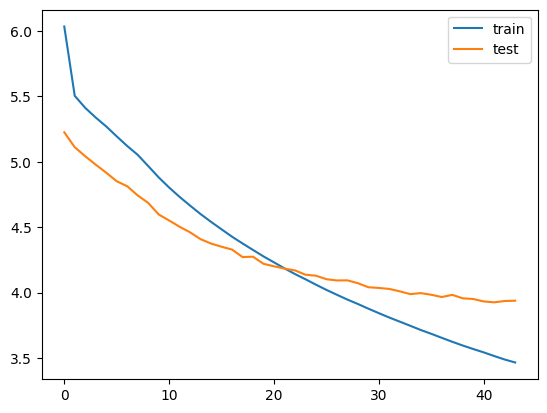

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [ ]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out,e_h, e_c])
        #print(output_tokens)
        #return
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_len_head-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c
    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
for i in range(0, 20):
    print("Review:",seq2text(padded_seq_tr[i]))
    print("Original summary:",seq2summary(y_seq_tr[i]))
    print("Predicted summary:",decode_sequence(padded_seq_tr[i].reshape(1,max_len_text)))
    print("\n")

Review: over 20 girls who were rescued from deoria shelter home after allegations of abuse were kept at a children home for boys for a week before being shifted to separate shelter homes this was revealed in a report by national commission for protection of child rights the girls were not provided a comfortable and safe space to recover report added 
Original summary: girls rescued from deoria shelter kept at boys home report 
1/1 [==============================] - 0s 20ms/step
Predicted summary:  2 dead in school shelter home in bihar shelter home


Review: talking about foreign companies building their business in india makemytrip ceo deep kalra has said we go overboard when we say atithi devo bhava further talking about not having a dearth of smart people in the country he also said we can create and build our own ecosystem that we are proud of n 
Original summary: we go overboard when we say atithi devo bhava makemytrip ceo 
1/1 [==============================] - 0s 20ms/step
Predi